# 2D Plane Strain FEA — scikit-fem

2D finite element analysis of the CCS bistable beam using `scikit-fem` (pure Python).

**Approach**: Triangulate the beam polygon, apply plane strain elasticity with
geometrically nonlinear (updated Lagrangian) solver, sweep prescribed center
displacement, extract reaction forces.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import triangle as tr
import skfem
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.helpers import dot, ddot, sym_grad, transpose, eye, grad, det, inv

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS, get_beam_polygon,
    get_beam_centerline,
)

print(f"scikit-fem version: {skfem.__version__}")

# Parameters
L = DEFAULT_BEAM_PARAMS["span"]
h = DEFAULT_BEAM_PARAMS["initial_offset"]
t = POLY_SI["t"]
E = POLY_SI["E"]
nu = POLY_SI["nu"]
lam, mu = lame_parameters(E, nu)
print(f"Lamé: λ={lam:.1f}, μ={mu:.1f} MPa")

scikit-fem version: 12.0.1
Lamé: λ=51522.2, μ=65573.8 MPa


## 1. Mesh Generation from Beam Polygon

In [2]:
# Get beam polygon (closed, Nx2)
poly = get_beam_polygon(n_points=600)

# Remove closing point for triangle (it wants open polyline with segment list)
if np.allclose(poly[0], poly[-1]):
    poly = poly[:-1]

n_verts = len(poly)
segments = np.column_stack([np.arange(n_verts), (np.arange(n_verts) + 1) % n_verts])

# Triangle input
tri_input = {
    'vertices': poly,
    'segments': segments,
}

# Triangulate with quality constraints
# 'p' = PSLG, 'q30' = min angle 30°, 'a' = max area
max_area = 0.005  # µm² — fine enough for 0.5 µm wide flex sections
tri_out = tr.triangulate(tri_input, f'pq30a{max_area}')

nodes = tri_out['vertices']
elems = tri_out['triangles']
print(f"Mesh: {len(nodes)} nodes, {len(elems)} triangles")

Mesh: 6093 nodes, 10973 triangles


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


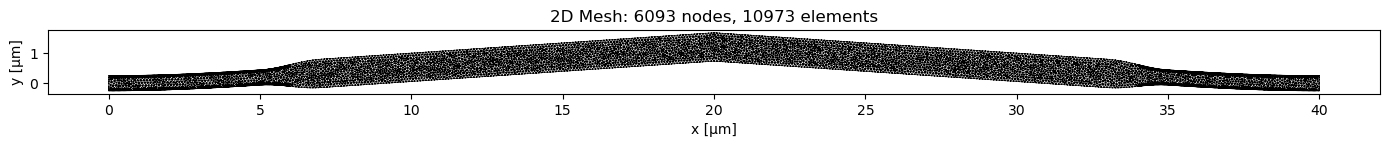

In [3]:
# Create scikit-fem mesh
mesh = MeshTri(nodes.T, elems.T)

# Visualize mesh
fig, ax = plt.subplots(figsize=(14, 4))
mesh.draw(ax=ax)
ax.set_aspect('equal')
ax.set_title(f'2D Mesh: {mesh.nvertices} nodes, {mesh.nelements} elements')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

fig.tight_layout()
fig.savefig('plots/skfem_2d_mesh.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Identify Boundary Nodes

Left anchor nodes: 10
Right anchor nodes: 9
Center band nodes: 64
Centerline y at x=L/2: 1.200 µm


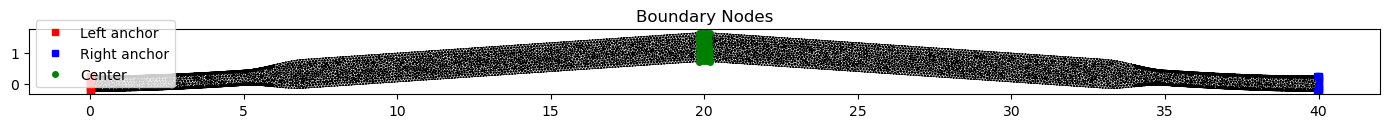

In [4]:
# Boundary identification based on x-coordinate
tol = 0.05  # µm tolerance for boundary detection

# Left anchor: nodes near x = 0
left_nodes = np.where(mesh.p[0] < tol)[0]

# Right anchor: nodes near x = L
right_nodes = np.where(mesh.p[0] > L - tol)[0]

# Center nodes: near x = L/2 (within a small band)
center_band = 0.2  # µm
center_nodes = np.where(np.abs(mesh.p[0] - L/2) < center_band)[0]

# Among center nodes, find the ones closest to the centerline
# (we'll prescribe displacement at these)
x_cl, y_cl = get_beam_centerline()
y_center = np.interp(L/2, x_cl, y_cl)  # y of centerline at x=L/2

print(f"Left anchor nodes: {len(left_nodes)}")
print(f"Right anchor nodes: {len(right_nodes)}")
print(f"Center band nodes: {len(center_nodes)}")
print(f"Centerline y at x=L/2: {y_center:.3f} µm")

# Visualize boundaries
fig, ax = plt.subplots(figsize=(14, 4))
mesh.draw(ax=ax)
ax.plot(mesh.p[0, left_nodes], mesh.p[1, left_nodes], 'rs', ms=4, label='Left anchor')
ax.plot(mesh.p[0, right_nodes], mesh.p[1, right_nodes], 'bs', ms=4, label='Right anchor')
ax.plot(mesh.p[0, center_nodes], mesh.p[1, center_nodes], 'go', ms=4, label='Center')
ax.legend()
ax.set_aspect('equal')
ax.set_title('Boundary Nodes')
fig.tight_layout()
plt.show()

## 3. Linear Elasticity Sweep

Quick validation with linear elastic solver. This won't capture snap-through
properly but gives us a baseline and verifies the mesh and BCs.

In [5]:
# Element and basis
elem = ElementTriP2()  # Quadratic triangles
ib = Basis(mesh, ElementVector(elem))

# Assemble linear elastic stiffness
K = linear_elasticity(lam, mu).assemble(ib)

# DOF indices for vector field: u_x at node i -> 2*i, u_y at node i -> 2*i+1
# scikit-fem ElementVector interleaves: DOF order is [u0x, u0y, u1x, u1y, ...]
# Actually, scikit-fem uses block ordering: [u_x for all nodes, u_y for all nodes]
n_dofs_scalar = ib.Nbfun // 2

# For ElementVector basis, DOFs are organized as:
# First n_dofs_scalar DOFs are x-component, next n_dofs_scalar are y-component
# So for node i: x-DOF = i, y-DOF = i + n_dofs_scalar

print(f"Total DOFs: {ib.Nbfun}")
print(f"DOFs per component: {n_dofs_scalar}")

# Build DOF sets for boundary conditions
# Need to map mesh node indices to DOF indices in the P2 basis
# For P2, vertex DOFs come first, then edge midpoint DOFs
# Vertex nodes are indexed 0..nvertices-1

# Fixed anchor DOFs (both components)
anchor_nodes = np.concatenate([left_nodes, right_nodes])
fixed_x_dofs = anchor_nodes  # x-component DOFs
fixed_y_dofs = anchor_nodes + n_dofs_scalar  # y-component DOFs
fixed_dofs = np.concatenate([fixed_x_dofs, fixed_y_dofs])

# Center node DOFs for prescribed displacement
center_x_dofs = center_nodes  # x: free (or zero if we want pure y-displacement)
center_y_dofs = center_nodes + n_dofs_scalar  # y: prescribed

Total DOFs: 12
DOFs per component: 6


In [6]:
# Linear displacement sweep
n_disp_steps = 100
delta_max = -2 * h  # Push down from initial offset to snapped state
delta_vals = np.linspace(0, delta_max, n_disp_steps)

F_linear = np.zeros(n_disp_steps)

for i, delta in enumerate(delta_vals):
    # All fixed DOFs + center y-DOFs are constrained
    all_constrained = np.concatenate([fixed_dofs, center_y_dofs])
    
    # Prescribed values: 0 for anchors, delta for center y
    prescribed = np.zeros(len(all_constrained))
    prescribed[len(fixed_dofs):] = delta  # center y displacement
    
    # Solve with condensation
    u = solve(*condense(K, np.zeros(ib.Nbfun), D=all_constrained, x=prescribed))
    
    # Reaction force at center nodes: F = K @ u at constrained DOFs
    f_react = K @ u
    F_linear[i] = np.sum(f_react[center_y_dofs])

print(f"Linear sweep done. F range: [{F_linear.min():.4f}, {F_linear.max():.4f}] µN")

IndexError: index 12 is out of bounds for axis 0 with size 12

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(-delta_vals, F_linear, 'b-', linewidth=1.5, label='Linear elastic (skfem 2D)')
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Center displacement δ [µm]')
ax.set_ylabel('Reaction force [µN]')
ax.set_title('Linear Elastic Response (no geometric nonlinearity)')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 4. Geometrically Nonlinear Solver (Total Lagrangian)

For large deformations (snap-through), we need geometric nonlinearity.
We use a Total Lagrangian formulation with Green-Lagrange strain
and 2nd Piola-Kirchhoff stress.

Newton-Raphson iteration at each displacement step.

In [ ]:
from skfem.assembly import BilinearForm, LinearForm

@BilinearForm
def stiffness_nl(u, v, w):
    """Tangent stiffness for Total Lagrangian with St. Venant-Kirchhoff material.
    
    Green-Lagrange strain: E = 0.5*(F^T F - I) where F = I + grad(u)
    S = λ tr(E) I + 2μ E  (2nd Piola-Kirchhoff)
    
    Tangent stiffness = material stiffness + geometric stiffness
    """
    # Current displacement gradient
    du = grad(w['prev'])  # 2x2 displacement gradient from previous iteration
    F = eye(du, 2) + du  # Deformation gradient
    
    # Green-Lagrange strain
    GL = 0.5 * (transpose(F) @ F - eye(du, 2))
    
    # 2nd Piola-Kirchhoff stress
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * eye(du, 2) + 2.0 * mu * GL
    
    # Variation of displacement gradient
    dv = grad(v)
    dw = grad(u)
    
    # Material tangent contribution
    dGL = 0.5 * (transpose(F) @ dw + transpose(dw) @ F)
    trDE = dGL[0, 0] + dGL[1, 1]
    dS = lam * trDE * eye(du, 2) + 2.0 * mu * dGL
    
    dGL_v = 0.5 * (transpose(F) @ dv + transpose(dv) @ F)
    
    # Material stiffness
    k_mat = ddot(dS, dGL_v)
    
    # Geometric stiffness
    k_geo = ddot(S, 0.5 * (transpose(dw) @ dv + transpose(dv) @ dw))
    
    return k_mat + k_geo


@LinearForm
def internal_forces(v, w):
    """Internal force vector (residual) for Total Lagrangian."""
    du = grad(w['prev'])
    F = eye(du, 2) + du
    
    GL = 0.5 * (transpose(F) @ F - eye(du, 2))
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * eye(du, 2) + 2.0 * mu * GL
    
    dv = grad(v)
    dGL_v = 0.5 * (transpose(F) @ dv + transpose(dv) @ F)
    
    return ddot(S, dGL_v)

print("Nonlinear forms defined.")

In [ ]:
# Nonlinear displacement sweep with Newton-Raphson
n_nl_steps = 200
delta_nl = np.linspace(0, -2*h, n_nl_steps)
F_nl = np.zeros(n_nl_steps)

# Incremental approach: use previous solution as initial guess
u_current = np.zeros(ib.Nbfun)

max_newton = 50
nl_tol = 1e-8

for i, delta in enumerate(delta_nl):
    # Set prescribed displacements
    u_target = u_current.copy()
    u_target[fixed_dofs] = 0.0
    u_target[center_y_dofs] = delta
    
    # Newton-Raphson iteration
    u_iter = u_target.copy()
    # Free DOFs: everything except anchors and center-y
    all_constrained = np.concatenate([fixed_dofs, center_y_dofs])
    
    converged = False
    for newton_iter in range(max_newton):
        # Assemble tangent stiffness and internal forces at current state
        u_field = ib.interpolate(u_iter)
        
        Kt = stiffness_nl.assemble(ib, prev=u_field)
        fint = internal_forces.assemble(ib, prev=u_field)
        
        # Residual = internal forces (no external forces applied)
        residual = fint.copy()
        
        # Zero residual at constrained DOFs
        residual[all_constrained] = 0.0
        
        res_norm = np.linalg.norm(residual)
        if res_norm < nl_tol:
            converged = True
            break
        
        # Solve for correction (only free DOFs)
        du_corr = solve(*condense(Kt, -residual, D=all_constrained))
        u_iter += du_corr
    
    if not converged and i > 0:
        print(f"  Step {i}: δ={delta:.4f}, Newton did not converge (res={res_norm:.2e})")
    
    u_current = u_iter.copy()
    
    # Extract reaction force at center
    u_field = ib.interpolate(u_current)
    fint = internal_forces.assemble(ib, prev=u_field)
    F_nl[i] = np.sum(fint[center_y_dofs])
    
    if i % 50 == 0:
        print(f"  Step {i}/{n_nl_steps}: δ={delta:.3f} µm, F={F_nl[i]:.4f} µN")

print("Nonlinear sweep complete.")

In [ ]:
# Plot nonlinear force-displacement
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(-delta_nl, F_nl, 'r-', linewidth=2, label='Nonlinear (skfem 2D)')
ax.plot(-delta_vals, F_linear, 'b--', linewidth=1, alpha=0.5, label='Linear (skfem 2D)')

# Load analytical for comparison
try:
    ana_data = np.loadtxt('results/analytical_force_displacement.csv',
                          delimiter=',', skiprows=1)
    ax.plot(ana_data[:, 0], ana_data[:, 2], 'k:', linewidth=1.5,
            label='Analytical CCS')
except FileNotFoundError:
    print("(Analytical results not yet available for overlay)")

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Center displacement δ [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('scikit-fem 2D Plane Strain — Force vs Displacement')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/skfem_2d_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Deformed Shapes

In [ ]:
# Re-solve at a few key displacements for visualization
key_deltas = [0.0, -h/2, -h, -1.5*h, -2*h]
key_labels = ['δ=0', f'δ={h/2:.1f}', f'δ={h:.1f}', f'δ={1.5*h:.1f}', f'δ={2*h:.1f}']

fig, ax = plt.subplots(figsize=(14, 6))

# Draw undeformed mesh lightly
ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, 'k-', alpha=0.1, linewidth=0.3)

colors = plt.cm.viridis(np.linspace(0, 1, len(key_deltas)))

u_vis = np.zeros(ib.Nbfun)
for k, (delta, label) in enumerate(zip(key_deltas, key_labels)):
    # Find closest step in our sweep
    idx = np.argmin(np.abs(delta_nl - delta))
    
    # Re-solve at this delta via Newton (quick since we have good initial guess)
    u_vis[:] = 0.0
    u_vis[fixed_dofs] = 0.0
    u_vis[center_y_dofs] = delta
    
    all_bc = np.concatenate([fixed_dofs, center_y_dofs])
    for _ in range(max_newton):
        u_field = ib.interpolate(u_vis)
        Kt = stiffness_nl.assemble(ib, prev=u_field)
        fint = internal_forces.assemble(ib, prev=u_field)
        residual = fint.copy()
        residual[all_bc] = 0.0
        if np.linalg.norm(residual) < nl_tol:
            break
        du_c = solve(*condense(Kt, -residual, D=all_bc))
        u_vis += du_c
    
    # Plot deformed shape (vertex nodes only)
    nv = mesh.nvertices
    ux = u_vis[:nv]
    uy = u_vis[n_dofs_scalar:n_dofs_scalar+nv]
    ax.triplot(mesh.p[0] + ux, mesh.p[1] + uy, mesh.t.T,
               '-', color=colors[k], linewidth=0.5, label=label)

ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title('Deformed Beam Shapes (2D Plane Strain)')
ax.legend(fontsize=9)

fig.tight_layout()
fig.savefig('plots/skfem_2d_deformed_shapes.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Von Mises Stress at Snap-Through

In [ ]:
# Compute stress at snap-through displacement
delta_snap_approx = -h  # approximate snap-through point

u_snap = np.zeros(ib.Nbfun)
u_snap[center_y_dofs] = delta_snap_approx
all_bc = np.concatenate([fixed_dofs, center_y_dofs])

for _ in range(max_newton):
    u_field = ib.interpolate(u_snap)
    Kt = stiffness_nl.assemble(ib, prev=u_field)
    fint = internal_forces.assemble(ib, prev=u_field)
    residual = fint.copy()
    residual[all_bc] = 0.0
    if np.linalg.norm(residual) < nl_tol:
        break
    du_c = solve(*condense(Kt, -residual, D=all_bc))
    u_snap += du_c

# Compute Green-Lagrange strain and 2nd PK stress at each element
# Then convert to von Mises
u_field = ib.interpolate(u_snap)

@Functional
def von_mises_field(w):
    du = grad(w['prev'])
    F = eye(du, 2) + du
    GL = 0.5 * (transpose(F) @ F - eye(du, 2))
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * eye(du, 2) + 2.0 * mu * GL
    # von Mises from 2nd PK stress (approximate, plane strain)
    s11, s22, s12 = S[0, 0], S[1, 1], S[0, 1]
    s33 = lam * trE  # plane strain: σ_zz = ν(σ_xx + σ_yy) approx
    vm = np.sqrt(0.5 * ((s11-s22)**2 + (s22-s33)**2 + (s33-s11)**2 + 6*s12**2))
    return vm

# Evaluate von Mises at element centroids
# We need element-wise evaluation, so let's compute manually
elem_basis = Basis(mesh, ElementTriP1())  # For element-wise values

# Compute stress at each quadrature point of each element
e2 = Basis(mesh, ElementVector(ElementTriP1()))

# Simpler approach: compute strain at element centroids
centroids_x = np.mean(mesh.p[0, mesh.t], axis=0)
centroids_y = np.mean(mesh.p[1, mesh.t], axis=0)

# Use displacement at vertices to estimate strain via finite differences
nv = mesh.nvertices
ux_v = u_snap[:nv]
uy_v = u_snap[n_dofs_scalar:n_dofs_scalar+nv]

# Per-element strain estimate (from vertex displacements)
vm_elem = np.zeros(mesh.nelements)
for ei in range(mesh.nelements):
    ni = mesh.t[:, ei]
    x_e = mesh.p[0, ni]
    y_e = mesh.p[1, ni]
    ux_e = ux_v[ni]
    uy_e = uy_v[ni]
    
    # Shape function derivatives for linear triangle
    # N = [1-ξ-η, ξ, η], dN/dx via Jacobian
    J = np.array([[x_e[1]-x_e[0], x_e[2]-x_e[0]],
                  [y_e[1]-y_e[0], y_e[2]-y_e[0]]])
    detJ = np.linalg.det(J)
    if abs(detJ) < 1e-15:
        continue
    Jinv = np.linalg.inv(J)
    dNdx = Jinv @ np.array([[-1, 1, 0], [-1, 0, 1]])
    
    # Displacement gradient
    dudx = np.outer(ux_e, dNdx[0]) .sum() 
    dudy = np.dot(ux_e, dNdx[1])
    dvdx = np.dot(uy_e, dNdx[0])
    dvdy = np.dot(uy_e, dNdx[1])
    
    H = np.array([[dudx, dudy], [dvdx, dvdy]])
    F_def = np.eye(2) + H
    GL = 0.5 * (F_def.T @ F_def - np.eye(2))
    
    trE = GL[0,0] + GL[1,1]
    S_pk = lam * trE * np.eye(2) + 2.0 * mu * GL
    s11, s22, s12 = S_pk[0,0], S_pk[1,1], S_pk[0,1]
    s33 = lam * trE
    vm_elem[ei] = np.sqrt(0.5*((s11-s22)**2 + (s22-s33)**2 + (s33-s11)**2 + 6*s12**2))

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
tpc = ax.tripcolor(mesh.p[0] + ux_v, mesh.p[1] + uy_v, mesh.t.T,
                    facecolors=vm_elem, cmap='hot')
fig.colorbar(tpc, ax=ax, label='von Mises stress [MPa]')
ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title(f'Von Mises Stress at δ = {abs(delta_snap_approx):.1f} µm (deformed config)')

fig.tight_layout()
fig.savefig('plots/skfem_2d_stress_contour.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Max von Mises stress: {vm_elem.max():.1f} MPa")

## 7. Save Results

In [ ]:
np.savetxt('results/skfem_2d_force_displacement.csv',
           np.column_stack([-delta_nl, F_nl]),
           delimiter=',',
           header='delta_um,F_uN',
           comments='')

print("Saved: results/skfem_2d_force_displacement.csv")
print(f"\nForce range: [{F_nl.min():.4f}, {F_nl.max():.4f}] µN")